#Before to start
Manually copy the dataset file `'train_128x128.npz'` in a directory in your Google Drive and move to that directory

Import the needed python modules.
Add here all the python module you need to complete the homework.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.utils import shuffle

#Connect to Google Drive
Mount Google Drive into Colaboratory,
then move the work directory to the Google Drive directory where you copied the dataset file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Homework')

Mounted at /content/drive


#Load the training set and print information
The dataset spatial resolution is `128x128` and it fits in the RAM of the Colaboratory virtual machine. Avoid duplicating the dataset in memory multiple times. If you have memory problems, subsample all the images along rows and columns using the `numpy array slicing`.

In this cell we also define the `class_names` tuple to associate class indexes with the corresponding label (either `'cat'` or `'dog'`).

In this cell we load the train set, then we made a split in order to divide the original set into two sets: train set (with 8500 cats and 8500 dogs, 85% of the original size) and validation set (with 1500 cats and 1500 dogs, 15% of the original size). At the end of this cell we shuffled both sets, then we performed save operation in order to use the validation set after separately.

In [ ]:
train = np.load('train_128x128.npz', allow_pickle=True)

X_train = train['X_train']
y_train = train['y_train']

training_samples, img_rows, img_cols, img_channels = X_train.shape

# extract validation set
X_val = X_train[np.r_[8500:10000, 18500:20000]]
y_val = y_train[np.r_[8500:10000, 18500:20000]]

# extract train set
X_train = X_train[np.r_[0:8500, 10000:18500]]
y_train = y_train[np.r_[0:8500, 10000:18500]]

np.random.seed(1000)

X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)

np.savez('trainANDvalidation.npz', X_train=X_train,
         y_train=y_train, X_val=X_val, y_val=y_val)

Here train and validation set are loaded and some information of the sets and their elements are displayed

In [ ]:
train = np.load('trainANDvalidation.npz', allow_pickle=True)

X_train = train['X_train']
y_train = train['y_train']
X_val = train['X_val']
y_val = train['y_val']

training_samples, img_rows, img_cols, img_channels = X_train.shape

print('\nX_train:\n- shape', X_train.shape,'\n- type:', X_train.dtype,'\n- min value:', X_train.min(),'\n- max value:', X_train.max())
print('\ny_train:\n- shape', y_train.shape,'\n- type:', y_train.dtype,'\n- min value:', y_train.min(),'\n- max value:', y_train.max())
print('\nX_val:\n- shape', X_val.shape,'\n- type:', X_val.dtype,'\n- min value:', X_val.min(),'\n- max value:', X_val.max())
print('\ny_val:\n- shape', y_val.shape,'\n- type:', y_val.dtype,'\n- min value:', y_val.min(),'\n- max value:', y_val.max())

#bincount is used to count number of occurrencies of 0 and 1 in y_train and y_val
count_arr_train = np.bincount(y_train)
count_arr_val = np.bincount(y_val)

print("\nIn the train set there are "+str(count_arr_train[0])+" cats and "+str(count_arr_train[1])+" dog")
print("\nIn the validation set there are "+str(count_arr_val[0])+" cats and "+str(count_arr_val[1])+" dog")

class_names = ('cat', 'dog')
num_classes = 2


X_train:
- shape (17000, 128, 128, 3) 
- type: uint8 
- min value: 0 
- max value: 255

y_train:
- shape (17000,) 
- type: uint8 
- min value: 0 
- max value: 1

X_val:
- shape (3000, 128, 128, 3) 
- type: uint8 
- min value: 0 
- max value: 255

y_val:
- shape (3000,) 
- type: uint8 
- min value: 0 
- max value: 1

In the train set there are 8500 cats and 8500 dog

In the validation set there are 1500 cats and 1500 dog


# Sample visualization

In [ ]:
index = 0

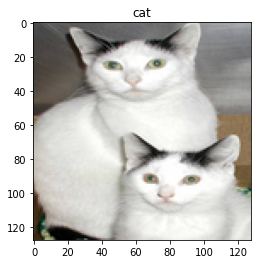

In [ ]:
#Shows a sample of train set
plt.imshow(X_train[index])
plt.title(class_names[y_train[index]])
index += 1

# Homework

Each team, composed of 4 students, must co-operate to train and validate a `keras model` using the provided dataset.

We will test your trained model on our private test set.
In order to fulfill your homework:

1.   Fill the shared Excel file with your team member contact information:
https://docs.google.com/spreadsheets/d/1Z7v2f5Atz2-WSfSmFw-E0Y1af5cP-rOWB_6g4BS4SdY/edit?usp=sharing


2.   Copy the directory containing the dataset file and code into your Google Drive:
https://drive.google.com/drive/folders/1eJFHrxCOGpZll9m9biW4MT4UhsahlFjL?usp=sharing

3.   Create a new Google Drive directory and rename it with your group number (from the Excel file);

4.   In this directory, save:
    1. a copy of your trained `keras model` in a subdirectory named `model`;
      * check that it can be loaded using the `load_model` keras function;
    2. a copy of your training notebook named `train.ipynb` containing the full training procedure implementation;
      * comment it to motivate your design choices;
    3. a copy of your test notebook named `test.ipynb` on your validation set;
      * run it and check that everything works as you expected;

5.   ONE STUDENT FOR EACH TEAM submit your Google Drive directory link. Provide us the team number, too.

6. CHECK AND DOUBLECHECK THAT THE SHARED LINK CAN BE ACCESSED BY ANYONE

7. Deadline 2022-04-27 at 12:00



# Train procedure


## Pre-processing of samples

Normalization of the data, each channel of the image is converted from the range 0-255 to 0-1

In [ ]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

Here the one_hot function is defined, then is used to create one hot for y_train and y_val

In [ ]:
def one_hot(a, n):
  e = np.eye(n) # Identity matrix n x n
  result=e[a.astype(np.uint8)]
  return result

y_train_1h = one_hot(y_train, num_classes)
y_val_1h = one_hot(y_val, num_classes)

print('\nBefore one-hot encoding:')
print(y_train[:10])

print('\nAfter one-hot encoding')
print(y_train_1h[:10])


Before one-hot encoding:
[0 0 0 0 0 1 1 1 1 0]

After one-hot encoding
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


## Training Preparation

We used categorical crossentropy instead of binary crossentropy as loss function in order to use names label (dog and cat) instead of 0 and 1.

In [ ]:
training_params = { # dizionario utile per compilare in seguito la rete
    'optimizer': 'adam',
    'loss': 'categorical_crossentropy', # 2 classi
    'metrics': ['accuracy']
}

##CNN

In [ ]:
# Instantiate an empty Sequential model
CNN = Sequential()

CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=(img_rows, img_cols, img_channels)))
CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
CNN.add(MaxPooling2D((2, 2)))
CNN.add(Dropout(0.25))

CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
CNN.add(MaxPooling2D((2, 2)))
CNN.add(Dropout(0.25))

CNN.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
CNN.add(MaxPooling2D((2, 2)))
CNN.add(Dropout(0.3))

CNN.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
CNN.add(MaxPooling2D((2, 2)))
CNN.add(Dropout(0.3))

# Flatten out the activation maps
CNN.add(Flatten())

# First fully-connected layer
CNN.add(Dense(64, activation='relu'))

CNN.add(Dropout(0.5))
# Second fully-connected layer
CNN.add(Dense(num_classes, activation='softmax'))

# Model summary
CNN.summary()

# Compile the model using the pre-defined training parameters
CNN.compile(**training_params)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

## Metriche

We use early stopping that allows us to stop after 20 epochs without improving the validation accuracy. 
We also use model checkpoint callback to save the weights of the model in the directory /model at each improve of the validation accuracy so the weights can be load later from the state saved.

In [ ]:
earlystopping_cb = EarlyStopping(monitor="val_accuracy", patience=20)

tensorboard_cnn_cb = TensorBoard(log_dir='./log')
modelcheckpoint_cnn_cb = ModelCheckpoint('./model', monitor="val_accuracy", save_best_only=True)

##Training CNN

For the training we set a maximum number of epochs equal to 200 and a batch size of 256.

In [ ]:
CNN.fit(X_train,
           y_train_1h,
           validation_data=(
               X_val,
               y_val_1h,
               ),
           epochs=200,
           batch_size=256,
           callbacks=[earlystopping_cb, modelcheckpoint_cnn_cb, tensorboard_cnn_cb])

Epoch 1/200
67/67 [==============================] - 75s 873ms/step - loss: 0.7115 - accuracy: 0.5159 - val_loss: 0.6845 - val_accuracy: 0.5133
Epoch 2/200
67/67 [==============================] - 53s 789ms/step - loss: 0.6585 - accuracy: 0.6085 - val_loss: 0.6217 - val_accuracy: 0.6793
Epoch 3/200
67/67 [==============================] - 55s 822ms/step - loss: 0.5864 - accuracy: 0.6907 - val_loss: 0.5438 - val_accuracy: 0.7217
Epoch 4/200
67/67 [==============================] - 55s 826ms/step - loss: 0.5447 - accuracy: 0.7342 - val_loss: 0.5165 - val_accuracy: 0.7487
Epoch 5/200
67/67 [==============================] - 55s 821ms/step - loss: 0.5126 - accuracy: 0.7526 - val_loss: 0.4691 - val_accuracy: 0.7710
Epoch 6/200
67/67 [==============================] - 55s 823ms/step - loss: 0.4721 - accuracy: 0.7800 - val_loss: 0.4423 - val_accuracy: 0.7917
Epoch 7/200
67/67 [==============================] - 56s 829ms/step - loss: 0.4375 - accuracy: 0.8063 - val_loss: 0.3971 - val_accuracy:

##Tensor board screenshots

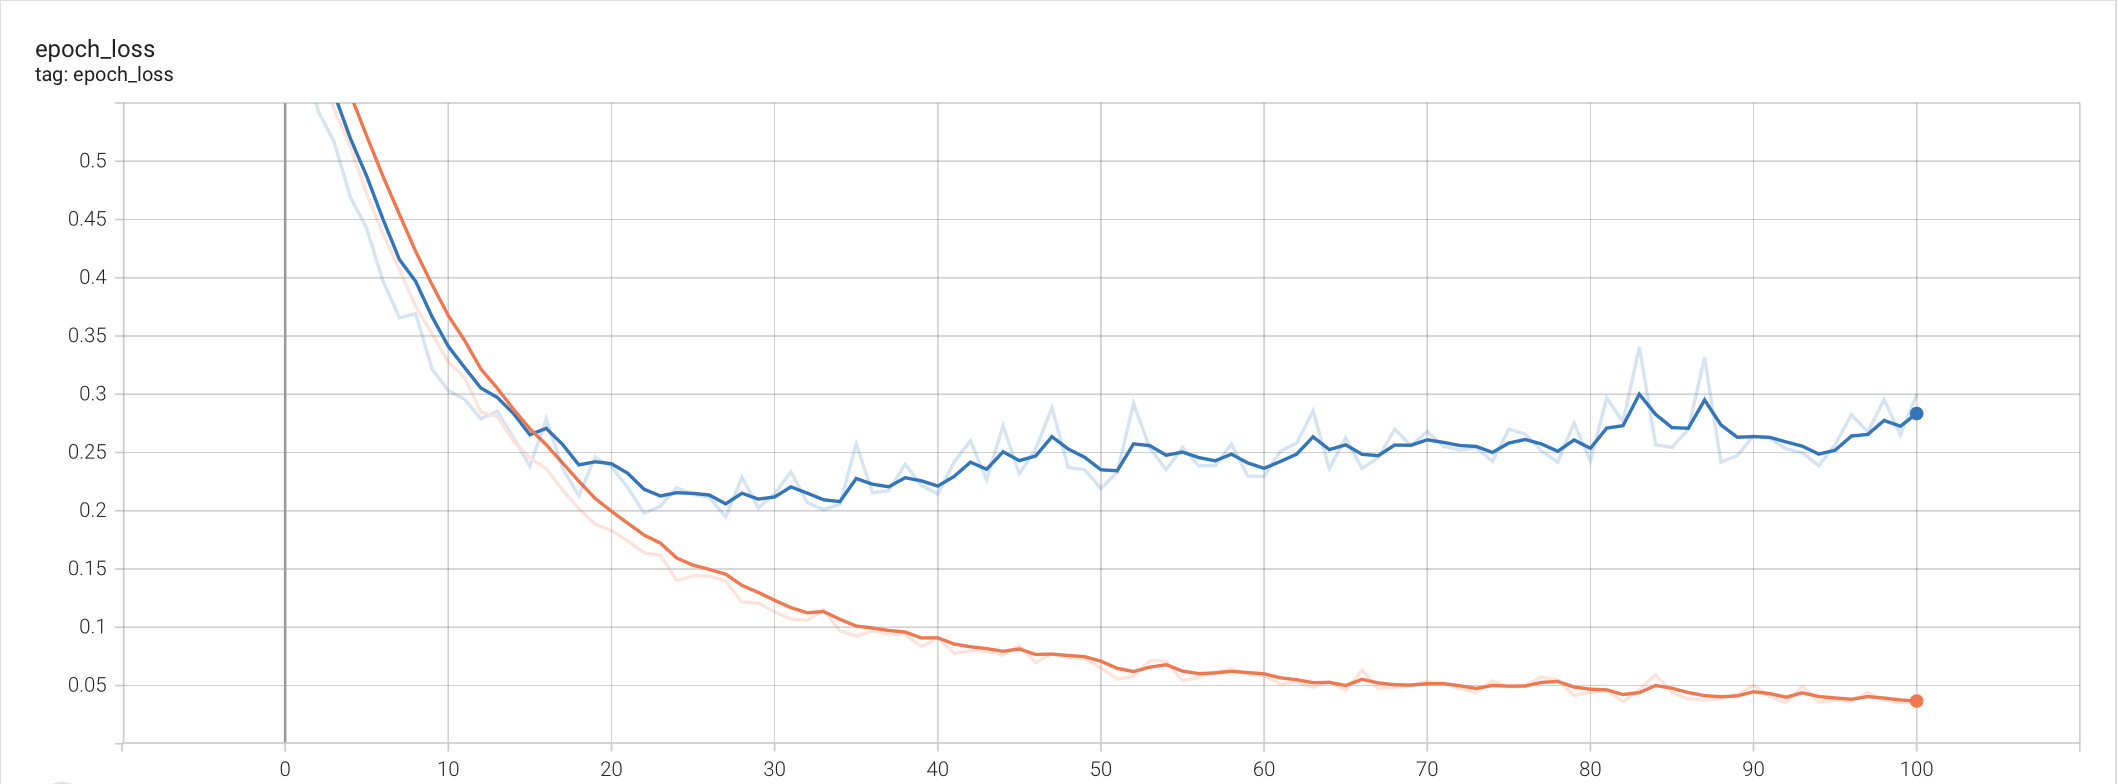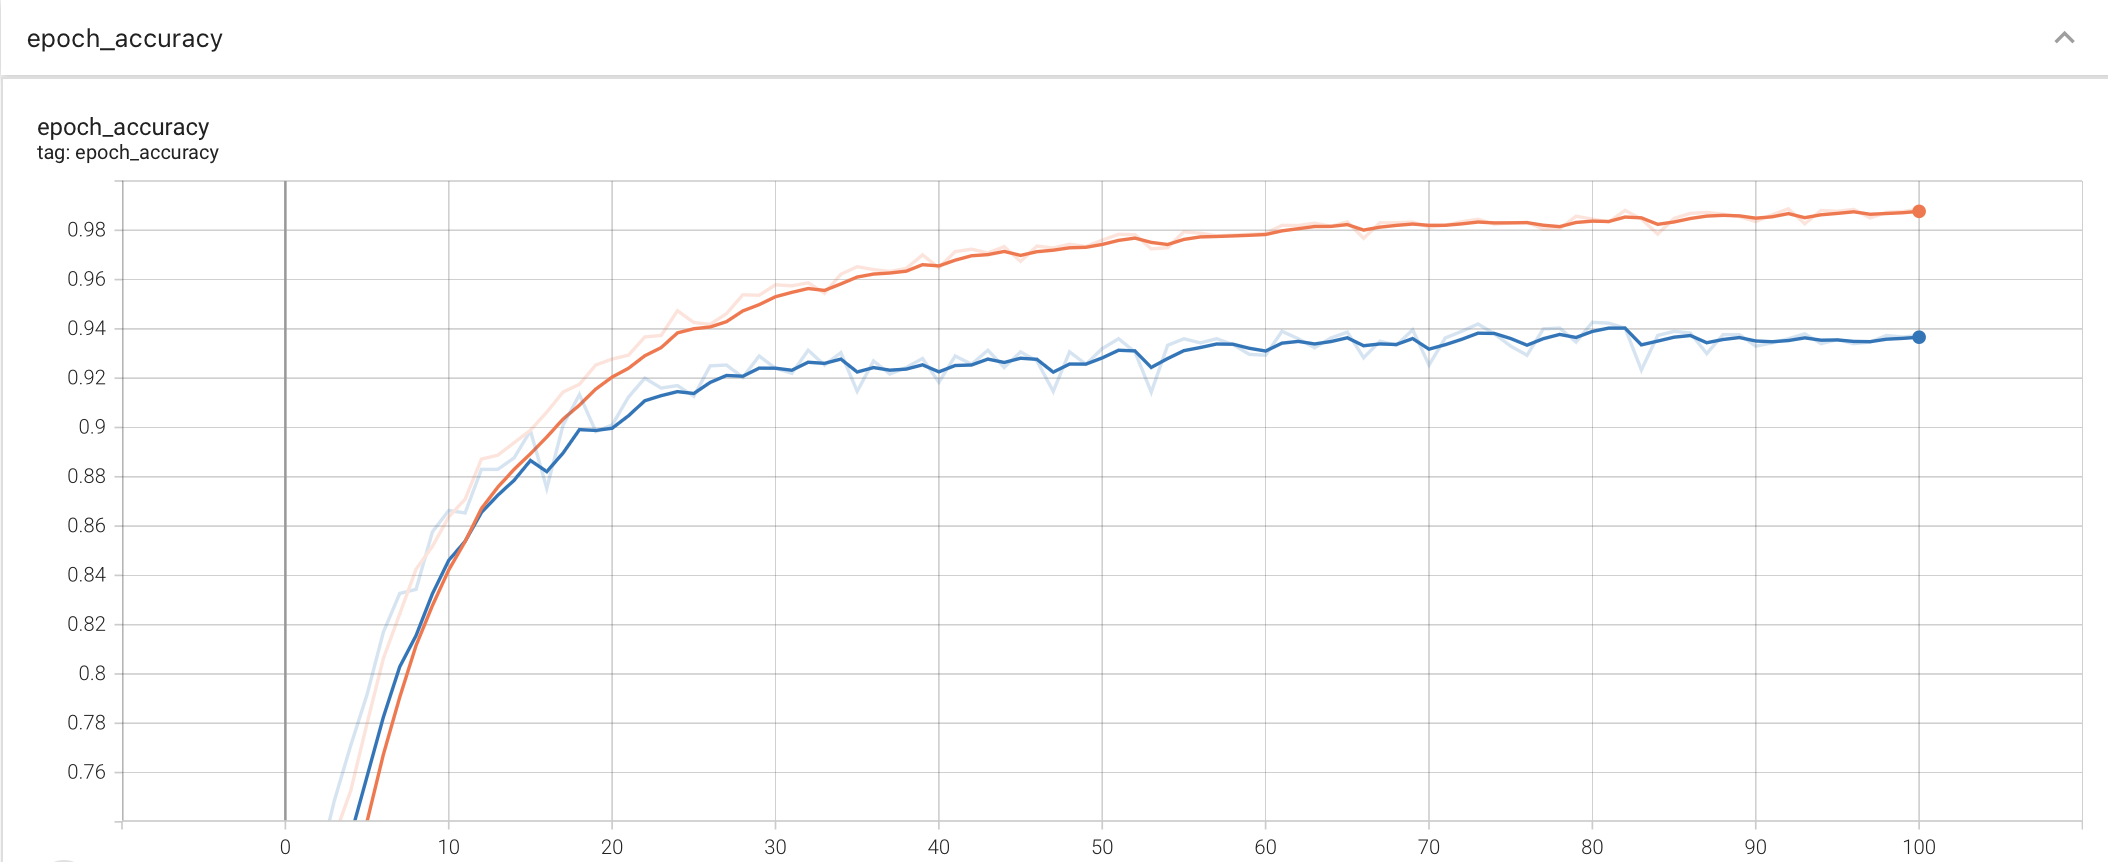